In [1]:
import os
import re
import sys

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset

%load_ext autoreload
%autoreload 2


sys.path.append(os.path.abspath("../"))

import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from src.data_utils import create_training_dataset
from src.model_xg import train_and_plot
from src.utils import compute_auc_roc, evaluate_prediction

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()

from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

scores = load_clean_scores(["2023-24"])
# scores = load_clean_scores()


# scores['outperform_next'] = scores.groupby('personId')['outperformed'].shift(-1)
scores.head(5)

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,outperform_next_5,outperform_next_10,injured_next,injured,fantasyDiff
390948,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,2544,lebron james,29.016667,10,16,0.625,1,4,0.25,0,1,0.0,1,7,8,5,1,0,0,1,21,7,40.50,49.35,0,1,False,False,0.0,0,-8.85
390949,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,False,False,1.0,1,-11.60
390950,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,202704,reggie jackson,24.066667,3,8,0.375,2,5,0.40,0,0,0.0,0,3,3,1,1,0,2,0,8,11,14.25,19.10,0,1,True,False,0.0,0,-4.85
390951,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,203076,anthony davis,34.150000,6,17,0.353,1,2,0.50,4,4,1.0,1,7,8,4,0,2,2,3,17,-17,36.00,51.80,0,1,True,True,0.0,0,-15.80
390952,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,203200,justin holiday,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.20,0,0,False,False,1.0,1,-8.20


Epoch 1/10, Loss: 0.6749
Epoch 2/10, Loss: 0.6728
Epoch 3/10, Loss: 0.6723
Epoch 4/10, Loss: 0.6720
Epoch 5/10, Loss: 0.6718
Epoch 6/10, Loss: 0.6712
Epoch 7/10, Loss: 0.6713
Epoch 8/10, Loss: 0.6709
Epoch 9/10, Loss: 0.6706
Epoch 10/10, Loss: 0.6705

Evaluation Metrics
----------------------------------------
Accuracy: 0.565
AUC (ROC): 0.577
F1 Score: 0.329
Precision: 0.512, Recall: 0.243
row_auc, accuracy, precision, recall, tnr
0.577, 0.565, 0.512, 0.243, 0.819

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2657  589]
 [1930  618]]

Confusion Matrix (Percent of Column):
[[57.92 48.8 ]
 [42.08 51.2 ]]
----------------------------------------
AUC: 0.5766474690260008


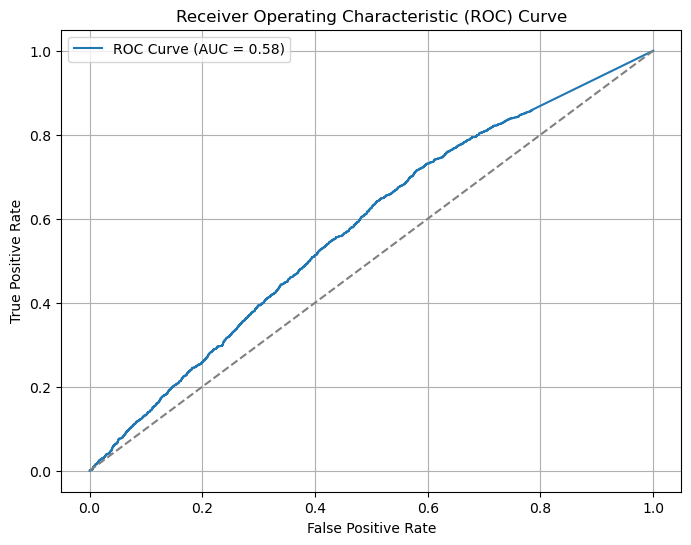

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        out = self.sigmoid(out)
        return out


class BasketballDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

non_lag_features = ["plusMinusPoints"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]

feature_columns = non_lag_features + lag_features
full_df = training_dct["df"]

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]


# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

# Convert target to numpy arrays
train_targets = train_df[target_col].values
test_targets = test_df[target_col].values

# Reshape data for LSTM (batch_size, sequence_length, num_features)
# Assume sequence_length = 1 (no temporal dependency in this case)
train_features = train_features[:, np.newaxis, :]
test_features = test_features[:, np.newaxis, :]

# Create datasets
train_dataset = BasketballDataset(train_features, train_targets)
test_dataset = BasketballDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
input_size = len(feature_columns)
hidden_size = 64
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# lr=0.000002
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    
model.eval()
y_probs = []
y_preds = []
y_true = []

prob_threshold = 0.5

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).squeeze()
        predictions = (outputs > prob_threshold).float()
        y_probs.extend(outputs.numpy())
        y_preds.extend(predictions.numpy())
        y_true.extend(targets.numpy())


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## LSTM w/ Injury

Epoch 1/10, Loss: 0.6745
Epoch 2/10, Loss: 0.6710
Epoch 3/10, Loss: 0.6692
Epoch 4/10, Loss: 0.6671
Epoch 5/10, Loss: 0.6635
Epoch 6/10, Loss: 0.6585
Epoch 7/10, Loss: 0.6499
Epoch 8/10, Loss: 0.6449
Epoch 9/10, Loss: 0.6418
Epoch 10/10, Loss: 0.6415

Evaluation Metrics
----------------------------------------
Accuracy: 0.571
AUC (ROC): 0.608
F1 Score: 0.443
Precision: 0.517, Recall: 0.387
row_auc, accuracy, precision, recall, tnr
0.608, 0.571, 0.517, 0.387, 0.716

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2324  922]
 [1561  987]]

Confusion Matrix (Percent of Column):
[[59.82 48.3 ]
 [40.18 51.7 ]]
----------------------------------------
AUC: 0.6079858823950453


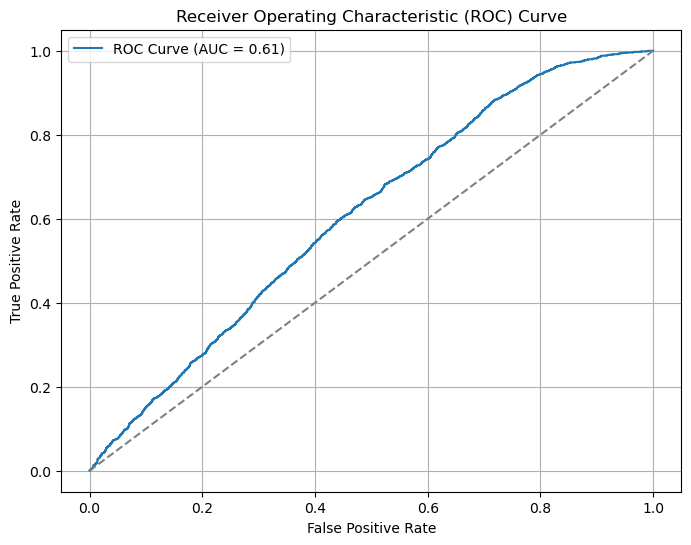

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        out = self.sigmoid(out)
        return out


class BasketballDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

non_lag_features = ["plusMinusPoints", "weighted_injured"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

feature_columns = non_lag_features + lag_features
full_df = training_dct["df"]

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]


# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

# Convert target to numpy arrays
train_targets = train_df[target_col].values
test_targets = test_df[target_col].values

# Reshape data for LSTM (batch_size, sequence_length, num_features)
# Assume sequence_length = 1 (no temporal dependency in this case)
train_features = train_features[:, np.newaxis, :]
test_features = test_features[:, np.newaxis, :]

# Create datasets
train_dataset = BasketballDataset(train_features, train_targets)
test_dataset = BasketballDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
input_size = len(feature_columns)
hidden_size = 64
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# lr=0.000002
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    
model.eval()
y_probs = []
y_preds = []
y_true = []

prob_threshold = 0.5

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).squeeze()
        predictions = (outputs > prob_threshold).float()
        y_probs.extend(outputs.numpy())
        y_preds.extend(predictions.numpy())
        y_true.extend(targets.numpy())


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## LSTM w/ Increased Playing Time

Epoch 1/10, Loss: 0.6736
Epoch 2/10, Loss: 0.6717
Epoch 3/10, Loss: 0.6710
Epoch 4/10, Loss: 0.6708
Epoch 5/10, Loss: 0.6705
Epoch 6/10, Loss: 0.6701
Epoch 7/10, Loss: 0.6694
Epoch 8/10, Loss: 0.6693
Epoch 9/10, Loss: 0.6691
Epoch 10/10, Loss: 0.6687

Evaluation Metrics
----------------------------------------
Accuracy: 0.568
AUC (ROC): 0.583
F1 Score: 0.343
Precision: 0.519, Recall: 0.257
row_auc, accuracy, precision, recall, tnr
0.583, 0.568, 0.519, 0.257, 0.813

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2639  607]
 [1894  654]]

Confusion Matrix (Percent of Column):
[[58.22 48.14]
 [41.78 51.86]]
----------------------------------------
AUC: 0.5826937343969296


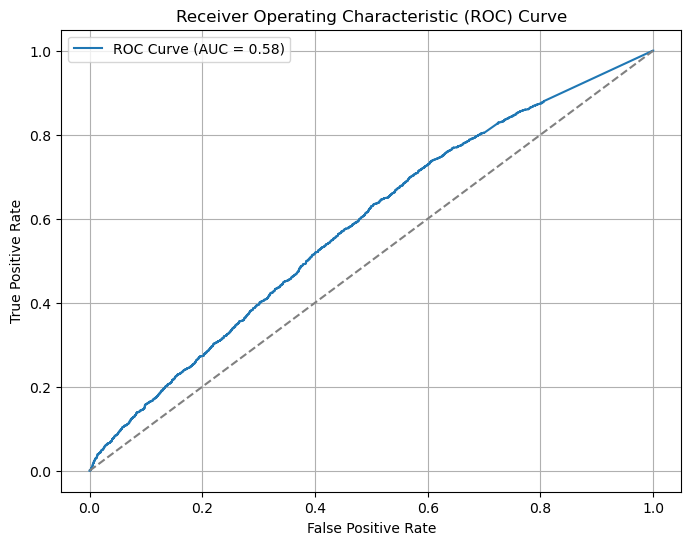

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        out = self.sigmoid(out)
        return out


class BasketballDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

non_lag_features = ["plusMinusPoints", "increase_playing_time"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

feature_columns = non_lag_features + lag_features
full_df = training_dct["df"]
def playing_time_thresholds(current, previous):
    diff = current - previous
    if diff >= 20:
        return 1
    elif diff >= 15:
        return 0.5
    elif diff < -15:
        return -0.5
    elif diff < -20:
        return -1
    else:
        return 0
df["increase_playing_time"] = df.apply(
    lambda row: playing_time_thresholds(row["minutes"], row["minutes_lag_1"]), axis=1
)

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]


# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

# Convert target to numpy arrays
train_targets = train_df[target_col].values
test_targets = test_df[target_col].values

# Reshape data for LSTM (batch_size, sequence_length, num_features)
# Assume sequence_length = 1 (no temporal dependency in this case)
train_features = train_features[:, np.newaxis, :]
test_features = test_features[:, np.newaxis, :]

# Create datasets
train_dataset = BasketballDataset(train_features, train_targets)
test_dataset = BasketballDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
input_size = len(feature_columns)
hidden_size = 64
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# lr=0.000002
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    
model.eval()
y_probs = []
y_preds = []
y_true = []

prob_threshold = 0.5

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).squeeze()
        predictions = (outputs > prob_threshold).float()
        y_probs.extend(outputs.numpy())
        y_preds.extend(predictions.numpy())
        y_true.extend(targets.numpy())


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## LSTM w/ All LLM Features

Epoch 1/10, Loss: 0.6741
Epoch 2/10, Loss: 0.6696
Epoch 3/10, Loss: 0.6667
Epoch 4/10, Loss: 0.6648
Epoch 5/10, Loss: 0.6632
Epoch 6/10, Loss: 0.6604
Epoch 7/10, Loss: 0.6584
Epoch 8/10, Loss: 0.6549
Epoch 9/10, Loss: 0.6484
Epoch 10/10, Loss: 0.6450

Evaluation Metrics
----------------------------------------
Accuracy: 0.572
AUC (ROC): 0.615
F1 Score: 0.440
Precision: 0.519, Recall: 0.382
row_auc, accuracy, precision, recall, tnr
0.615, 0.572, 0.519, 0.382, 0.722

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[2344  902]
 [1575  973]]

Confusion Matrix (Percent of Column):
[[59.81 48.11]
 [40.19 51.89]]
----------------------------------------
AUC: 0.6151323425716084


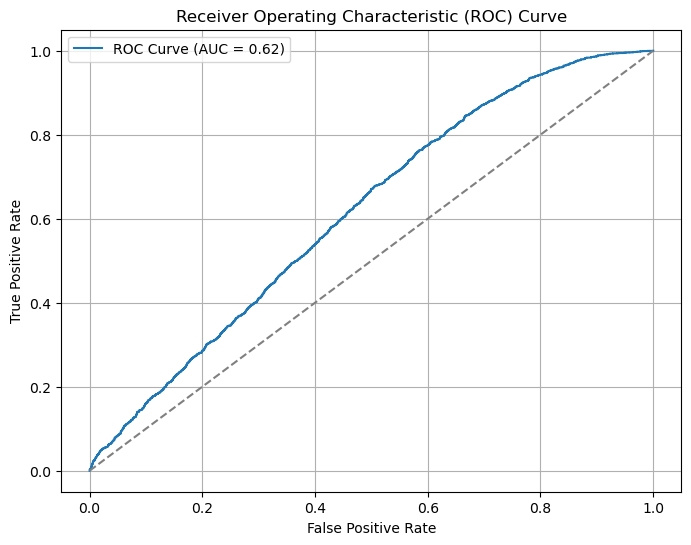

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        out = self.sigmoid(out)
        return out


class BasketballDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

non_lag_features = ["plusMinusPoints", "weighted_injured", "increase_playing_time"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperform_next"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

feature_columns = non_lag_features + lag_features
full_df = training_dct["df"]
def playing_time_thresholds(current, previous):
    diff = current - previous
    if diff >= 20:
        return 1
    elif diff >= 15:
        return 0.5
    elif diff < -15:
        return -0.5
    elif diff < -20:
        return -1
    else:
        return 0
df["increase_playing_time"] = df.apply(
    lambda row: playing_time_thresholds(row["minutes"], row["minutes_lag_1"]), axis=1
)

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]


# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

# Convert target to numpy arrays
train_targets = train_df[target_col].values
test_targets = test_df[target_col].values

# Reshape data for LSTM (batch_size, sequence_length, num_features)
# Assume sequence_length = 1 (no temporal dependency in this case)
train_features = train_features[:, np.newaxis, :]
test_features = test_features[:, np.newaxis, :]

# Create datasets
train_dataset = BasketballDataset(train_features, train_targets)
test_dataset = BasketballDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
input_size = len(feature_columns)
hidden_size = 64
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# lr=0.000002
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    
model.eval()
y_probs = []
y_preds = []
y_true = []

prob_threshold = 0.5

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).squeeze()
        predictions = (outputs > prob_threshold).float()
        y_probs.extend(outputs.numpy())
        y_preds.extend(predictions.numpy())
        y_true.extend(targets.numpy())


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)